In [1]:
# Topic Modeling  
### @Author : Woojin Park, Nidhi Bhaskar
### @Copyright : 2020, Neolth NSF grant NLP project 
### @Email : woojinpa@andrew.cmu.edu , nidhibha@andrew.cmu.edu
### @Status : In-Progress

In [2]:
### Import Relevant Libraries
import os
import pandas as pd
import numpy as np
import collections
import datetime as dt
import requests
import json
import re
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from scipy.stats import norm
from IPython.display import display, Image



import string
import re
import nltk
from nltk.util import ngrams
from nltk import pos_tag,word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF

In [3]:
### Build a get_date function to convert date format
#### Build a data_creation function to read json data into pandas dataframe

def get_date(created):
    return dt.datetime.fromtimestamp(created)

def data_creation(subreddit) : 
    with open('submissions_'+subreddit+'.json') as f:
        data = json.loads("[" + 
            f.read().replace("}\n{", "},\n{") + 
        "]")
    data =pd.DataFrame(data)
    reddit_data = data[['author','over_18','title','selftext','num_comments', 'score', 'full_link','created_utc']]
    reddit_data = reddit_data.dropna()
    _timestamp = reddit_data["created_utc"].apply(get_date)
    reddit_data = reddit_data.assign(timestamp = _timestamp)
    reddit_data['over_18'] = reddit_data['over_18'].astype('str')
    reddit_data['subreddit']= subreddit
    # Build column have title + selftext
    reddit_data['title_with_selftext']= reddit_data['title'] +" " + reddit_data['selftext']

    # Do one more extra cleaning : keep updating this part
    reddit_data=reddit_data[~reddit_data['title_with_selftext'].isin([ '[removed]', '[deleted]',''])]
    subreddit = reddit_data    
    return subreddit

def empty_words_clean(text):
    text = text.replace('[removed]','')
    text= text.replace('[deleted]','')
    text= text.replace('\n','')
    return (text)

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [5]:
### Dataframing 4 subreddit Datasets
SuicideWatch_df = data_creation('SuicideWatch')
depressed_df = data_creation('depressed')
happy_df = data_creation('happy')
selfimprovement_df = data_creation('selfimprovement')

### Concat all 4 dataframes into one merged file
all_subreddit_df = pd.concat([SuicideWatch_df,depressed_df,happy_df,selfimprovement_df])

In [6]:
### 0.Data Preparation

In [7]:
#### Text Preprocessing by following pipeline : 
### Raw text => Tokeninze/lowercase => Remove stop words => Remove non-alphabetic characters => 
### Remove Extra Punctuations => Lemmatization => Build Custom Stop words dictionary 

In [8]:
# Build function that takes a word and returns true if it consists only of non-alphabetic characters
def alpha_filter(w):
    pattern = re.compile('^[^a-z]+$')
    if (pattern.match(w)):
        return True
    else:
        return False
    
# Build data preparation function including all the necessary 7 steps :
def clean_words(text):
    # lower text & tokenizing
    text = text.replace('\n',' ')
    text = text.replace('[removed]',' ')
    text= text.replace('[deleted]', '')
    text =text.lower()
    
    ### Updated cleaning-pipeline : 
    text = re.sub(r'[^a-zA-Z0-9 ]',r' ',text) #remove anything that is not a letter or number first
    text = [word for word in text.split(" ")]
    
    # remove stop words
    nltk_stopwords = set(stopwords.words('english'))
    review_lower_stop = [x for x in text if not x in nltk_stopwords]
    # remove extra punctuations
    review_lower_stop_pun = [y for y in review_lower_stop if not alpha_filter(y)]
    review_lower_stop_pun_extra = [''.join(x for x in par if x not in string.punctuation) for par in review_lower_stop_pun]
    # Lemmatization
    porter = WordNetLemmatizer()
    review_lower_stop_pun_extra_lemmatized = []
    for a in review_lower_stop_pun_extra : 
        review_lower_stop_pun_extra_lemmatized.append(porter.lemmatize(a))
    # buid custom stop words dictionary
    cachedStopWords = set(stopwords.words("english"))

    ####Keep Updating custom stop words
    cachedStopWords.update(('nt', 'wo', 're', 'im', 'yall','u','ca','ive', 'wan','na','gon','nov','x200b','amp',\
                        'wwwyoutubecomwatch','http','vbjkbl5olvm8','lt', 'br', 'gt', 'amp','tsp','tbsp','nbsp'))   
    review_lower_stop_pun_extra_lemmatized_stop = [x for x in review_lower_stop_pun_extra_lemmatized\
                                                   if not x in cachedStopWords]
    text = " ".join(review_lower_stop_pun_extra_lemmatized_stop)
    return (text)

def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

In [9]:
##Data Sampling

In [10]:
### Because of relatively huge dataset, we need to perform random sampling of 30% for now

all_subreddit_df_list = all_subreddit_df.sample(frac=0.3, replace=True, random_state=1)

In [11]:
all_subreddit_df_list["title_with_selftext_clean"] = all_subreddit_df_list["title_with_selftext"].apply(lambda x: clean_words(x))

In [12]:
all_subreddit_df_list['polarity'] = all_subreddit_df_list['title_with_selftext_clean'].apply(detect_polarity)

In [13]:
all_subreddit_df_list.head(3)

author over_18  \
12970           sudrawkid   False   
5192          PinkyIsSnug   False   
2357   ReasonableBrother3   False   

                                                   title  \
12970  Can't properly stick up for myself and feel weak.   
5192   Gonna kill myself very very soon. I've really ...   
2357                               GET RID OF DEPRESSION   

                                                selftext  num_comments  score  \
12970  Hey everyone! I guess I should just outright g...             2      4   
5192   I joined this school with high hopes. hopes th...             5      1   
2357                                           [removed]             0      1   

                                               full_link  created_utc  \
12970  https://www.reddit.com/r/selfimprovement/comme...   1533443455   
5192   https://www.reddit.com/r/SuicideWatch/comments...   1580935590   
2357   https://www.reddit.com/r/depressed/comments/g0...   1586839925   

                timestamp        subreddit  \
12970 2018-08-05 00:30:55  selfimprovement   
5192  2020-02-05 15:46:30     SuicideWatch   
2357  2020-04-14 00:52:05        depressed   

                                     title_with_selftext  \
12970  Can't properly stick up for myself and feel we...   
5192   Gonna kill myself very very soon. I've really ...   
2357                     GET RID OF DEPRESSION [removed]   

                               title_with_selftext_clean  polarity  
12970  properly stick feel weak  hey everyone  guess ... -0.116927  
5192   gonna kill soon  really tried year tipping poi... -0.028633  
2357                                get rid depression    0.000000

In [14]:
### Final check of cleaning pipeline's output/reliability

In [15]:
all_subreddit_df_list.title.head(1).tolist()

["Can't properly stick up for myself and feel weak."]

In [16]:
all_subreddit_df_list.selftext.head(1).tolist()

["Hey everyone! I guess I should just outright get into it. As a person I tend to be very meek and mild mannered, often apologizing for things that are literally not my fault at all. Because of this I think people tend to walk on me a bit and truth be told, I let them. I hate confrontation and it gives me the worst anxiety. However my issues is that I hold all my anger and frustration in that once I spot someone even weaker than I am I let it out on them and hard. (example: an acquaintance of mine was saying some not so nice but not serious stuff about me behind my back. I knew I could handle a confrontation with him and so I went IN to the point where I said some things that were unnecessarily mean.)\n\n I can't find that balance, and now my job is making my feelings of weakness even worse. I work in retail (I know it's horrid) but I am great customer service person, I'm very friendly and smile and all that but the sheer abuse I take from asshole customers on the daily is enough to ma

In [17]:
all_subreddit_df_list.title_with_selftext_clean.head(1).tolist()

['properly stick feel weak  hey everyone  guess outright get  person tend meek mild mannered  often apologizing thing literally fault  think people tend walk bit truth told  let  hate confrontation give worst anxiety  however issue hold anger frustration spot someone even weaker let hard   example  acquaintance mine saying nice serious stuff behind back  knew could handle confrontation went point said thing unnecessarily mean     find balance  job making feeling weakness even worse  work retail  know horrid  great customer service person  friendly smile sheer abuse take asshole customer daily enough make want cry get home  rude let   know work exactly clap back mean really let walk  point almost seems like know powerless often tell manager bad worker  despite fact probably one best customer service people work     anyway appropriately defend situation stop bottling anger unleashing deserve  feel weak willed time really crushing feel awful eventually snap  please help  thank ']

In [18]:
#Descriptive statistics & dataframe  info

In [19]:
all_subreddit_df_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47828 entries, 12970 to 43513
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   author                     47828 non-null  object        
 1   over_18                    47828 non-null  object        
 2   title                      47828 non-null  object        
 3   selftext                   47828 non-null  object        
 4   num_comments               47828 non-null  int64         
 5   score                      47828 non-null  int64         
 6   full_link                  47828 non-null  object        
 7   created_utc                47828 non-null  int64         
 8   timestamp                  47828 non-null  datetime64[ns]
 9   subreddit                  47828 non-null  object        
 10  title_with_selftext        47828 non-null  object        
 11  title_with_selftext_clean  47828 non-null  object        
 12  

In [20]:
all_subreddit_df_list.describe()

num_comments         score   created_utc      polarity
count  47828.000000  47828.000000  4.782800e+04  47828.000000
mean       6.214289     65.042590  1.557714e+09      0.076999
std       28.489875    966.074055  3.417972e+07      0.254898
min        0.000000      0.000000  1.304697e+09     -1.000000
25%        1.000000      1.000000  1.538144e+09     -0.038462
50%        2.000000      1.000000  1.570949e+09      0.039981
75%        5.000000      3.000000  1.584263e+09      0.194731
max     1825.000000  81714.000000  1.590173e+09      1.000000

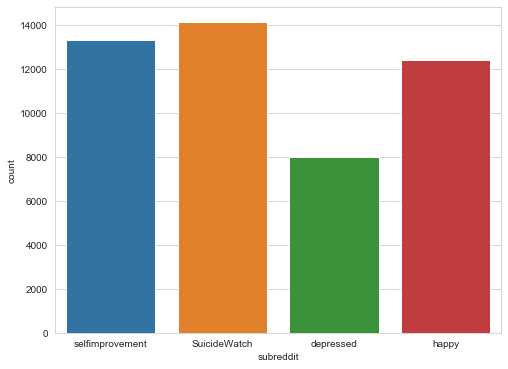

In [21]:
# Build Bar plot for all 4 subreddit distribution
plt.figure(figsize=(8,6))
sns.countplot(x='subreddit',data=all_subreddit_df_list)

In [22]:
## Polarity (Sentiment) distribution of all 4 subreddit - Symmetric/ not skewed

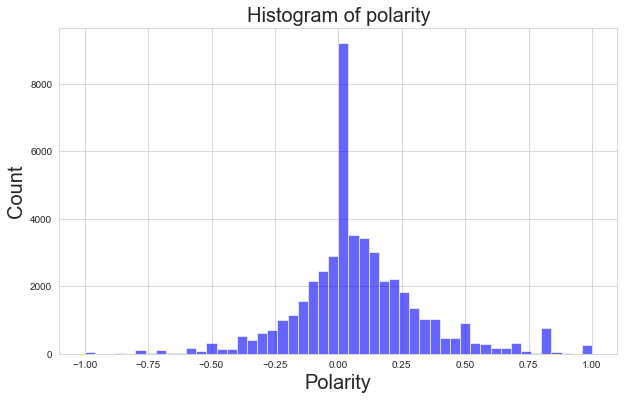

In [23]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(all_subreddit_df_list.polarity, num_bins, facecolor='blue', alpha=0.6)
plt.xlabel('Polarity',fontsize =20)
plt.ylabel('Count',fontsize =20)
plt.title('Histogram of polarity',fontsize =20)
plt.show()

## Topic Modeling : NMF

A type of statistical model for discovering the abstract "topics" that occur in a collection of documents. A document typically concerns multiple topics in different proportions; thus, in a document that is 10% about cats and 90% about dogs, there would probably be about 9 times more dog words than cat words. 

The "topics" produced by topic modeling techniques are clusters of similar words.

A topic model captures this intuition in a mathematical framework, which allows examining a set of documents and discovering, based on the statistics of the words in each, what the topics might be and what each document's balance of topics is.

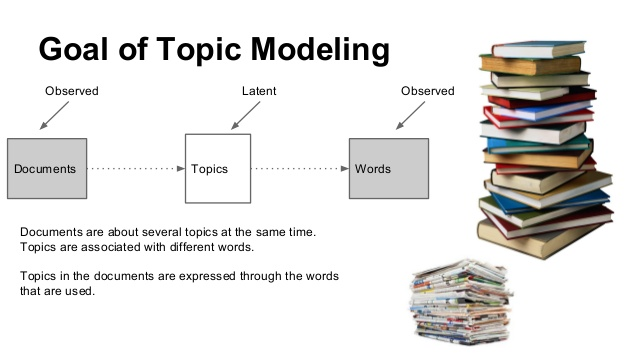

In [24]:
display(Image(filename='topic_modeling.png'))

### # Non-Negative Matrix Factorization (NMF) is an 'unsupervised' and the state of the art 'feature extraction' technique so there are no labeling of topics that the model will be trained on.
#### Simply, NMF is useful when there are many attributes and the attributes are ambiguous or have weak predictability (*especially like the dataset we have). By combining attributes, NMF can produce meaningful patterns, topics, or themes.

In a text document, the same word can occur in different places with different meanings. For example, "hike" can be applied to the outdoors or to interest rates. By combining attributes, NMF introduces context, which is essential for predictive power:


"hike" + "mountain" -> "outdoor sports" (Topic 1)

"hike" + "interest" -> "interest rates" (Topic 2)

The way it works is that,NMF provides two matrices of topics that are factorized from Document-Term Matrix.
One of two matrices is Document-Topic Matrix and the other is Topic-Term Matrix. 

#### NMF decomposes (or factorizes) high-dimensional word vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their "coefficients" are non-negative.

#### In our analysis, the high-dimensional vectors are going to be "TF-IDF" weights. *(term frequency-inverse document frequency : is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.)

But it can be anything including word vectors or a simple raw count of the words and tf-idf weights out of the text works well and is computationally not very expensive (i.e runs fast).

#### So, NMF is a deterministic algorithm which arrives at a single representation of the corpus and it arrives at its representation of a corpus in terms of something resembling “latent topics”.

In [25]:
### n : 47828, k:4, m :5000 (N unique features : We assigned it as 5000, from 9k)
### 47828 x9000 -> Factorize (47828 x4 ) X (4 x 5000)

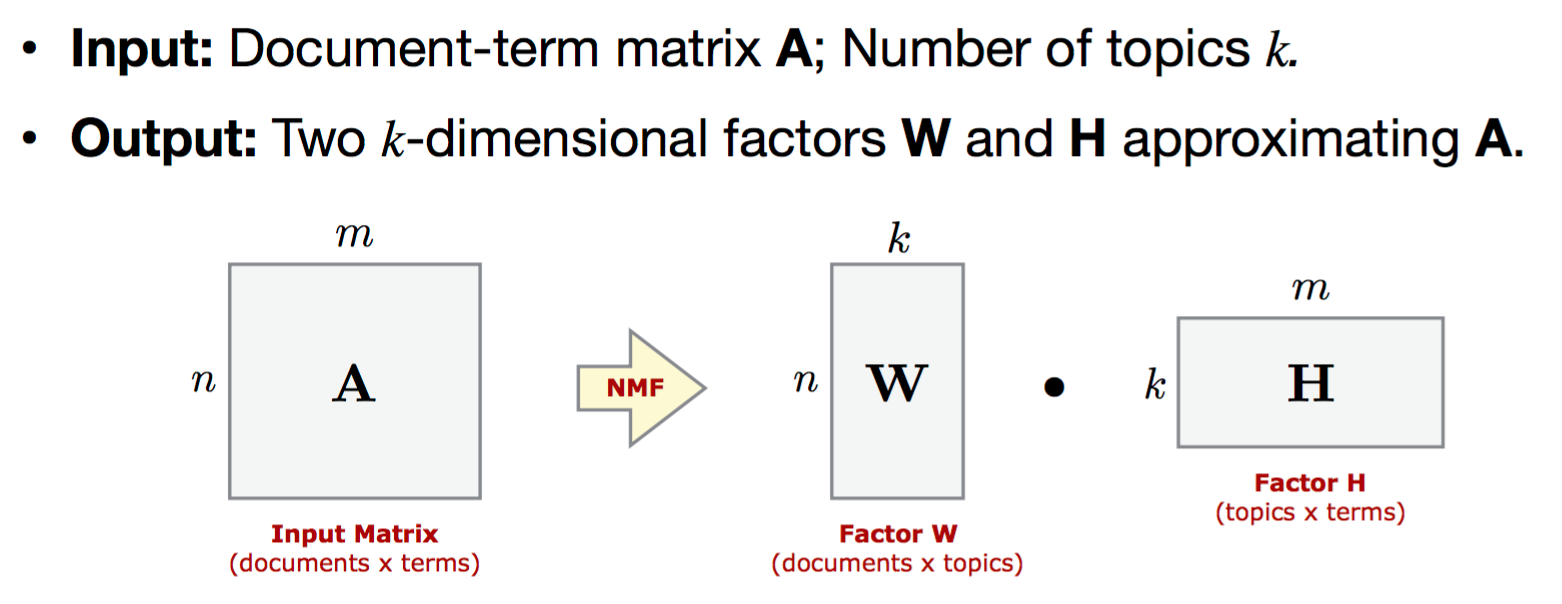

In [26]:
display(Image(filename='nmf.png'))

Although there are some variants,  popular way of measuring how good the approximation is the frobenius norm (the sum of element-wise squared distance errors). Formalizing this, we obtain the following objective

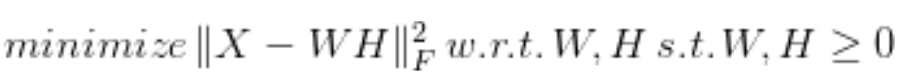

In [27]:
display(Image(filename='objective.png'))

NMF decomposes a data matrix A into the product of two lower rank matrices W and H so that A is approximately equal to W times H. NMF uses an iterative procedure to modify the initial values of W and H so that the product approaches A. The procedure terminates when the approximation error converges or the specified number of iterations is reached.

In [28]:
### Build NMF Model

In [29]:
# get topics with their terms and weights
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights, sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])
    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]
    return topics

# prints components of all the topics  obtained from topic modeling
def print_topics_udf(topics, total_topics=4,
                     weight_threshold=0.0001,
                     display_weights=False,
                     num_terms=None):

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        if display_weights:
            print('Topic'+str(index)+' with weights : ')
            print(topic[:num_terms]) if num_terms else topic
            print('\n')
        else:
            print('Topic #'+str(index)+' without weights : ')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw

In [63]:

def tfidf_nmf_function (dataframe, no_top_words, number) :
# Store only text contents
    data_text = dataframe[['title_with_selftext_clean']]
    data_text['index'] = dataframe.index
    # Assign to 'documents' which has texts and index of each
    documents = data_text
    ## Vectorization
    # NMF is able to use tf-idf - vectorize the corpus
    tfidf_vectorizer = TfidfVectorizer(max_df=0.80, min_df=10, max_features=6000,ngram_range=(1, 2)
                                   ,stop_words='english', token_pattern = r'\b[^\d\W]+\b')
    
    ## min_df = 10 : ignore words that appear in less than 10 of the subreddits
    ##  max_df=0.80 : model to ignore words that appear in more than 80% of the subreddits
    ## max_features=6000 : After processing we have a little over 9k(9688) unique words 
    ### so we’ll set the max_features to only include the top 6k 
    #### by term frequency across the articles for further feature reduction.
    ##  ngram_range=(1, 2) : tf-idf weights for n-grams (bigrams, trigrams etc.). 
    ### To do that we’ll set the n_gram range to (1, 2) 
    #### which will include unigrams and bigrams.
    
    
    # calculate the feature matrix
    tfidf = tfidf_vectorizer.fit_transform(dataframe['title_with_selftext_clean'])
    print( "Created %d X %d TF-IDF-normalized document-term matrix" % (tfidf.shape[0], tfidf.shape[1]) )
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()


    print ( "in the corpus of N documents, total of N unique features :")
    display(tfidf.shape)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    print("Length of unique features are : ", len(tfidf_vectorizer.get_feature_names()))

    # Run NMF  
    nmf = NMF(n_components=number, random_state=1, alpha=.3, l1_ratio=.5, init='nndsvd')
    
    ### Regularization ? 
    ####will lower the variance from the model - More robust decision on data as it minimize overfitting
    ##  ‘nndsvd’  :Nonnegative Double Singular Value Decomposition which works best on sparse data like we have here
    ##  As in ElasticNet, we control the combination of L1 (Lasso) and L2 (Ridge) with the l1_ratio (ρ) parameter
    ###between 0< - <1  and the intensity of the regularization with the alpha (α) parameter
    
    nmf_z = nmf.fit_transform(tfidf)
    nmf_weights = nmf.components_
    nmf_feature_names = tfidf_vectorizer.get_feature_names()


    for topic_idx, topic in enumerate(nmf.components_):
            print("Topic %d:" % (topic_idx))
            print(", ".join([tfidf_feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]) ,"\n")
            
    topics = get_topics_terms_weights(nmf_weights, nmf_feature_names)
    print_topics_udf(topics, total_topics=4, num_terms=30, display_weights=True)

    TopicNumber=[]
    for i in range(len(nmf_z)):
        h=nmf_z[i].tolist().index(nmf_z[i].max())
        TopicNumber.append(h)
    documents['topic_nmf']=TopicNumber
    dataframe['topic_nmf'] =TopicNumber
    sns.countplot(x='topic_nmf', data=documents)
  

In [64]:
### We are having better results with NMF (over TF-IDF matrix) than with LDA. 
### The top keywords of the topics NFM finds are more related and meaningful to the context of my corpus, 
###which are posts of many subjects shared internally in my organization.

/Users/Jay/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Created 47828 X 6000 TF-IDF-normalized document-term matrix
in the corpus of N documents, total of N unique features :


(47828, 6000)

Length of unique features are :  6000
Topic 0:
life, time, year, friend, know, people, thing, day, really, think, like, help, going, work, make, got, good, school, love, job, need, thought, way, better, self, month, say, lot, family, person 

Topic 1:
happy, make happy, make, today, finally, feel happy, year, day, love, birthday, happy life, dog, really happy, happy happy, want happy, smile, family, happiness, happy birthday, christmas, picture, little, video, place, happy new, new, happy today, got, baby, girl 

Topic 2:
feel, like, feel like, feeling, know, make feel, really, make, people, dont, sad, anymore, know feel, want, depressed, like feel, thing, like shit, shit, hate, want feel, good, bad, life feel, talk, think, felt, feeling like, better, feel better 

Topic 3:
want, die, want die, kill, fucking, anymore, dont, hate, live, know, end, life, tired, pain, want kill, wish, care, dont want, hurt, fuck, want live, wanna, alive, suicide, want end, shit, stop, death, die want, sca

/Users/Jay/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


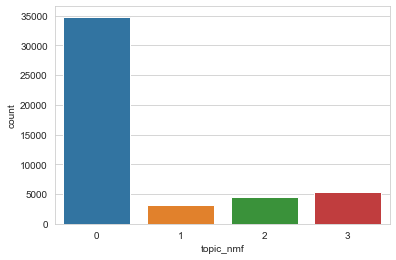

In [65]:
#def nmf_function (tfidf, model, feature_names, no_top_words) :
#nmf_function (tfidf,nmf, tfidf_feature_names, 20) 
#visualization topic distribution
tfidf_nmf_function(all_subreddit_df_list,30 ,4)

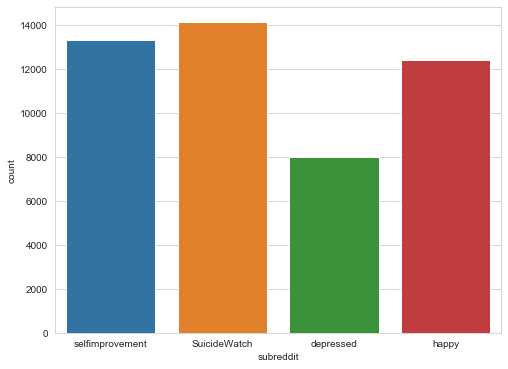

In [66]:
# Compare the Bar plot for all 4 subreddit distribution with above Topic modeling distribution
plt.figure(figsize=(8,6))
sns.countplot(x='subreddit',data=all_subreddit_df_list)

In [67]:
from collections import Counter 
print(Counter(all_subreddit_df_list.topic_nmf))

Counter({0: 34804, 3: 5328, 2: 4577, 1: 3119})


In [68]:
topic0_gr = all_subreddit_df_list[all_subreddit_df_list['topic_nmf'] ==0]
topic1_gr = all_subreddit_df_list[all_subreddit_df_list['topic_nmf'] ==1]
topic2_gr = all_subreddit_df_list[all_subreddit_df_list['topic_nmf'] ==2]
topic3_gr = all_subreddit_df_list[all_subreddit_df_list['topic_nmf'] ==3]

In [69]:
print(Counter(all_subreddit_df_list.subreddit))

Counter({'SuicideWatch': 14124, 'selfimprovement': 13298, 'happy': 12411, 'depressed': 7995})


In [70]:
print(Counter(topic0_gr.subreddit))

Counter({'selfimprovement': 11471, 'happy': 9255, 'SuicideWatch': 8539, 'depressed': 5539})


In [71]:
print(Counter(topic1_gr.subreddit))

Counter({'happy': 2605, 'depressed': 197, 'SuicideWatch': 176, 'selfimprovement': 141})


In [72]:
print(Counter(topic2_gr.subreddit))

Counter({'SuicideWatch': 1554, 'depressed': 1397, 'selfimprovement': 1188, 'happy': 438})


In [73]:
print(Counter(topic3_gr.subreddit))

Counter({'SuicideWatch': 3855, 'depressed': 862, 'selfimprovement': 498, 'happy': 113})


In [74]:
#Build a Weight-Term Dictionary DataFrame

In [78]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.80, min_df=10, max_features=6000,ngram_range=(1, 2)
                                   ,stop_words='english', token_pattern = r'\b[^\d\W]+\b')
tfidf = tfidf_vectorizer.fit_transform(all_subreddit_df_list['title_with_selftext_clean'])
nmf = NMF(n_components=4, random_state=1, alpha=.3, l1_ratio=.5, init='nndsvd')
nmf_output = nmf.fit_transform(tfidf)
nmf_feature_names = tfidf_vectorizer.get_feature_names()
nmf_weights = nmf.components_
feature_names = np.array(nmf_feature_names)
sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(nmf_weights))])
sorted_weights = np.array([list(wt[index]) for wt, index in zip(nmf_weights, sorted_indices)])
sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])
topics = get_topics_terms_weights(nmf_weights, nmf_feature_names)


weight_term_df=pd.DataFrame(nmf_weights).transpose()
weight_term_df['term']=nmf_feature_names
weight_term_df['max']=weight_term_df.max(axis=1)
weight_term_df =weight_term_df.set_axis(['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'term', 'max'], axis=1, inplace=False)

In [146]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 6000)
weight_term_df.head(10)

Topic 0  Topic 1  Topic 2  Topic 3         term       max
0  0.001754      0.0      0.0  0.00000      abandon  0.001754
1  0.028738      0.0      0.0  0.00000    abandoned  0.028738
2  0.000000      0.0      0.0  0.00000  abandonment  0.000000
3  0.103248      0.0      0.0  0.00000      ability  0.103248
4  0.571750      0.0      0.0  0.03155         able  0.571750
5  0.000000      0.0      0.0  0.00000  able afford  0.000000
6  0.000000      0.0      0.0  0.00000    able help  0.000000
7  0.013640      0.0      0.0  0.00000    able make  0.013640
8  0.012170      0.0      0.0  0.00000    able talk  0.012170
9  0.000852      0.0      0.0  0.00000    able work  0.000852

In [80]:
print_topics_udf(topics, total_topics=4, num_terms=30, display_weights=True)

Topic0 with weights : 
[('life', 2.68), ('time', 2.48), ('year', 2.34), ('friend', 2.2), ('know', 2.09), ('people', 2.02), ('thing', 2.0), ('day', 1.92), ('really', 1.83), ('think', 1.51), ('like', 1.51), ('help', 1.48), ('going', 1.38), ('work', 1.37), ('make', 1.33), ('got', 1.3), ('good', 1.29), ('school', 1.26), ('love', 1.24), ('job', 1.22), ('need', 1.2), ('thought', 1.17), ('way', 1.16), ('better', 1.09), ('self', 1.05), ('month', 1.04), ('say', 1.0), ('lot', 0.98), ('family', 0.95), ('person', 0.94)]


Topic1 with weights : 
[('happy', 8.94), ('make happy', 1.74), ('make', 1.15), ('today', 0.32), ('finally', 0.3), ('feel happy', 0.27), ('year', 0.25), ('day', 0.24), ('love', 0.23), ('birthday', 0.19), ('happy life', 0.18), ('dog', 0.18), ('really happy', 0.17), ('happy happy', 0.16), ('want happy', 0.14), ('smile', 0.14), ('family', 0.13), ('happiness', 0.13), ('happy birthday', 0.12), ('christmas', 0.1), ('picture', 0.1), ('little', 0.1), ('video', 0.1), ('place', 0.09), ('hap

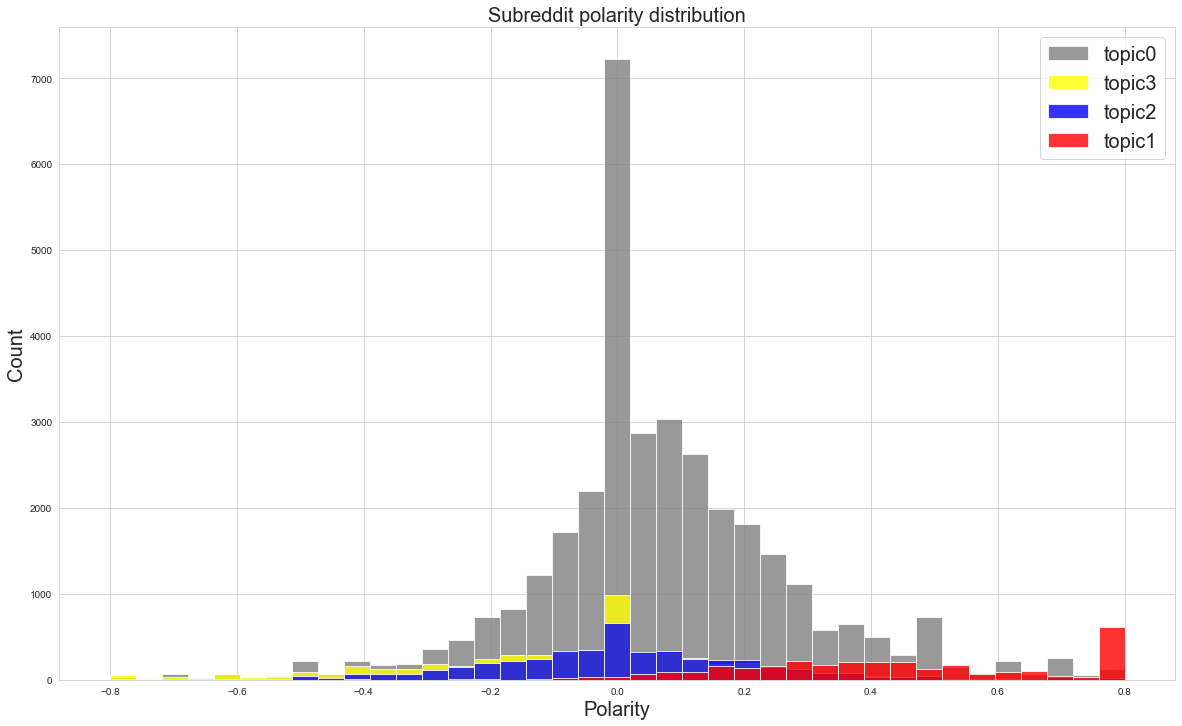

In [81]:
from matplotlib import pyplot
plt.figure(figsize=(20,12))
bins = np.linspace(-.8, .8, 40)

pyplot.hist(topic0_gr['polarity'], bins, alpha=0.8, label='topic0',color='grey')
pyplot.hist(topic3_gr['polarity'], bins, alpha=0.8, label='topic3',color='yellow')
pyplot.hist(topic2_gr['polarity'], bins, alpha=0.8, label='topic2',color='blue')
pyplot.hist(topic1_gr['polarity'], bins, alpha=0.8, label='topic1',color='red')

plt.xlabel('Polarity',fontsize =20)
plt.ylabel('Count',fontsize =20)
pyplot.legend(loc='upper right',fontsize=20)
plt.title('Subreddit polarity distribution',fontsize =20)

pyplot.show()

In [82]:
### Give term-weight example of each topic cluster's highest weighted words

In [83]:
##Topic 0

In [84]:
weight_term_df[weight_term_df['term']=='life']

Topic 0   Topic 1   Topic 2   Topic 3  term       max
2802  2.680113  0.059391  0.047689  0.881764  life  2.680113

In [85]:
##Topic 1

In [86]:
weight_term_df[weight_term_df['term']=='happy']

Topic 0   Topic 1  Topic 2  Topic 3   term       max
2146  0.21013  8.944098      0.0      0.0  happy  8.944098

In [87]:
##Topic 2

In [88]:
weight_term_df[weight_term_df['term']=='feel']

Topic 0   Topic 1   Topic 2   Topic 3  term       max
1579  0.732116  0.044509  7.262632  0.125261  feel  7.262632

In [89]:
##Topic 3

In [90]:
weight_term_df[weight_term_df['term']=='die']

Topic 0  Topic 1  Topic 2  Topic 3 term      max
1145      0.0      0.0      0.0  3.53933  die  3.53933

In [ ]:
## Some exceptional examples : can be one of the most important weight term in both Topic 0 and Topic 2

In [139]:
weight_term_df[weight_term_df['term']=='like']

Topic 0  Topic 1   Topic 2   Topic 3  term       max
2890  1.510057      0.0  5.573123  0.059722  like  5.573123

### Final check-up for Topic 3 (Latent Suicidal Ideation & Life TopicGroup) documents examples

In [118]:
all_subreddit_df_list[all_subreddit_df_list['topic_nmf']==3].tail(5)

author over_18  \
10174  myLuciferislonelyx   False   
11794         anon-lizard   False   
45726             lss3745   False   
31796        supahardpimp   False   
32880           [deleted]   False   

                                                   title  \
10174                                           me again   
11794  Struggling with chronic, intrusive, and obsess...   
45726                              Divorce after 8 years   
31796                                               help   
32880                    Can someone help me kill myself   

                                                selftext  num_comments  score  \
10174  I’m so fucking unwell and my life is completel...             2      1   
11794  I have been seeking treatment for my depressio...             1      1   
45726  My will be ex wife's words keep ringing in my ...             0      1   
31796  What do you do when your mental health has tak...             0      2   
32880                                          [deleted]             2      1   

                                               full_link  created_utc  \
10174  https://www.reddit.com/r/SuicideWatch/comments...   1582056523   
11794  https://www.reddit.com/r/SuicideWatch/comments...   1582435519   
45726  https://www.reddit.com/r/SuicideWatch/comments...   1589721311   
31796  https://www.reddit.com/r/SuicideWatch/comments...   1586891054   
32880  https://www.reddit.com/r/SuicideWatch/comments...   1587126019   

                timestamp     subreddit  \
10174 2020-02-18 15:08:43  SuicideWatch   
11794 2020-02-23 00:25:19  SuicideWatch   
45726 2020-05-17 09:15:11  SuicideWatch   
31796 2020-04-14 15:04:14  SuicideWatch   
32880 2020-04-17 08:20:19  SuicideWatch   

                                     title_with_selftext  \
10174  me again I’m so fucking unwell and my life is ...   
11794  Struggling with chronic, intrusive, and obsess...   
45726  Divorce after 8 years My will be ex wife's wor...   
31796  help What do you do when your mental health ha...   
32880          Can someone help me kill myself [deleted]   

                               title_with_selftext_clean  polarity  topic_nmf  
10174  fucking unwell life completely falling apart a... -0.237798          3  
11794  struggling chronic  intrusive  obsessive suici...  0.109596          3  
45726  divorce year ex wife word keep ringing head  t...  0.000000          3  
31796  help mental health taken life  know kill optio... -0.057071          3  
32880                                 someone help kill   0.000000          3

In [119]:
all_subreddit_df_list[all_subreddit_df_list['topic_nmf']==3].title.tail(5).tolist()

['me again',
 'Struggling with chronic, intrusive, and obsessive suicidal ideations',
 'Divorce after 8 years',
 'help',
 'Can someone help me kill myself']

In [121]:
all_subreddit_df_list[all_subreddit_df_list['topic_nmf']==3].selftext.tail(5).tolist()

['I’m so fucking unwell and my life is completely falling apart around me, and doing anything is a chore, my body hurts, I know fine well I’m fighting with myself, in my head everyday when it’s calling me and shaming me all day long, it’s me, I do it to myself but it won’t stop, and every time it speaks it hurts so bad, I’m a lost cause I honestly fucking hate myself I’m ready to fucking die honest to god I wish someone would just put a fucking gun to my head because I’m too fucking pathetic to do it myself. \n\nYes I have told this to my care manager and my mother and my friends. People care, which makes this all harder my mother would be devastated, but not a single one of them understand how much pain I am in, everyone’s telling me to put all this work in, I’ve been fighting with myself for 8 years and now I am fucking DONE',
 'I have been seeking treatment for my depression and suicidal ideations and have been diagnosed with treatment resistant depression. Part of me knows I should

In [120]:
all_subreddit_df_list[all_subreddit_df_list['topic_nmf']==3].title_with_selftext_clean.tail(5).tolist()

['fucking unwell life completely falling apart around  anything chore  body hurt  know fine well fighting  head everyday calling shaming day long   stop  every time speaks hurt bad  lost cause honestly fucking hate ready fucking die honest god wish someone would put fucking gun head fucking pathetic    yes told care manager mother friend  people care  make harder mother would devastated  single one understand much pain  everyone telling put work  fighting year fucking done',
 'struggling chronic  intrusive  obsessive suicidal ideation seeking treatment depression suicidal ideation diagnosed treatment resistant depression  part know want die want live  part want end suffering  want anyone question enough  everyone everything  fucked  therapist trying best tell thought frustrating     seems easier give  point life living barely    know would  want write suicide letter    suicide hotlines bullshit please suggest try  last time  told try essential oil lol',
 'divorce year ex wife word keep

In [91]:
## so basically using this coefficient of each term and  document scores 
## we can decompose each document into a weighted sum of topics

DataFrame after Topic Modeling -> This dataframe will be used for BERT: classification modeling 

In [135]:
all_subreddit_df_list.tail(1)

author over_18          title  \
43513  qourkening   False  Borrowed time   

                                                selftext  num_comments  score  \
43513  It never got easier for me, all the people tha...             0      1   

                                               full_link  created_utc  \
43513  https://www.reddit.com/r/SuicideWatch/comments...   1589291785   

                timestamp     subreddit  \
43513 2020-05-12 09:56:25  SuicideWatch   

                                     title_with_selftext  \
43513  Borrowed time It never got easier for me, all ...   

                               title_with_selftext_clean  polarity  topic_nmf  
43513  borrowed time never got easier  people tried h...  -0.08125          0

In [137]:
all_subreddit_df_list.title_with_selftext.tail(1).tolist()

['Borrowed time It never got easier for me, all the people that have tried to help me make me feel worse, I\'ve held on far longer than I ever expected and it went back to people hating me. Couple of full circles in my life\n\nI cant even talk to the "professionals" anymore, the anxiety is teamed up with the depression again. I am delusional to think posting on reddit would help me, when I cant even use my phone anymore. \n\nNo one ever cares about us on the level we need, believing all those lies created nothing but more trauma and wasted time. I know it was all my fault, and I am fucking sorry']

In [147]:
all_subreddit_df_list[all_subreddit_df_list['topic_nmf']==2].tail(10)

author over_18  \
26071        purplebandaids   False   
20971              Raydus73   False   
37686            MeelinFelo   False   
4072           ShadeJasmine   False   
28818       ominousskeleton   False   
4913              [deleted]   False   
6441       cartmanselection   False   
22425               talcobh   False   
13612  coffees-n-chocolates   False   
34576     PerlenceSubrange3   False   

                                                   title  \
26071               i feel like I’m going to hurt myself   
20971                       Insecurity about big breasts   
37686  I feel like the luckiest girl in the world wit...   
4072                                   Not looking good.   
28818  I graduated college a few weeks ago, and just ...   
4913   Just wanted to post an updated transformation ...   
6441      This is my first post that got over 600 likes.   
22425  Being Social: Accepting who you are vs trying ...   
13612                I have lost interest in everything.   
34576  Any advice on how to fix subconscious low self...   

                                                selftext  num_comments  score  \
26071  I just want to die. My mom doesn’t care about ...             2      1   
20971  A close friend of mine feels extremely insecur...             8      0   
37686                                                                1      1   
4072   It isn't looking good for me. I can feel the e...             3      3   
28818                                                                5     35   
4913                                           [deleted]             3      2   
6441                                                                 8     67   
22425  In my journey to self improvement so far, I fe...             9     38   
13612  I lack motivation to do anything. I struggle m...             2      1   
34576  I'm in this weird place atm where I feel like ...             3      1   

                                               full_link  created_utc  \
26071  https://www.reddit.com/r/SuicideWatch/comments...   1585623047   
20971  https://www.reddit.com/r/selfimprovement/comme...   1552308457   
37686  https://www.reddit.com/r/happy/comments/f4gewg...   1581803605   
4072   https://www.reddit.com/r/depressed/comments/4y...   1471568169   
28818  https://www.reddit.com/r/happy/comments/bzj407...   1560292058   
4913   https://www.reddit.com/r/happy/comments/7gcuy0...   1511958259   
6441   https://www.reddit.com/r/happy/comments/7p8e1k...   1515516964   
22425  https://www.reddit.com/r/selfimprovement/comme...   1555270710   
13612  https://www.reddit.com/r/depressed/comments/g5...   1587435154   
34576  https://www.reddit.com/r/selfimprovement/comme...   1576397299   

                timestamp        subreddit  \
26071 2020-03-30 22:50:47     SuicideWatch   
20971 2019-03-11 08:47:37  selfimprovement   
37686 2020-02-15 16:53:25            happy   
4072  2016-08-18 20:56:09        depressed   
28818 2019-06-11 18:27:38            happy   
4913  2017-11-29 07:24:19            happy   
6441  2018-01-09 11:56:04            happy   
22425 2019-04-14 15:38:30  selfimprovement   
13612 2020-04-20 22:12:34        depressed   
34576 2019-12-15 03:08:19  selfimprovement   

                                     title_with_selftext  \
26071  i feel like I’m going to hurt myself I just wa...   
20971  Insecurity about big breasts A close friend of...   
37686  I feel like the luckiest girl in the world wit...   
4072   Not looking good. It isn't looking good for me...   
28818  I graduated college a few weeks ago, and just ...   
4913   Just wanted to post an updated transformation ...   
6441     This is my first post that got over 600 likes.    
22425  Being Social: Accepting who you are vs trying ...   
13612  I have lost interest in everything. I lack mot...   
34576  Any advice on how to fix subconscious low self...   

                               title_with_selftext_clean  polarity

In [149]:
all_subreddit_df_list[all_subreddit_df_list['topic_nmf']==2].selftext.tail(10).tolist()

['I just want to die. My mom doesn’t care about me or that I am sick with a fever but she takes off work for a week because “she may have carona or get it’”. She has no symptoms. I honestly hate being here with her. I rather fucking kill myself. I feel like I’m going crazy because I just want to scream and cry suddenly, like I’m having a mental breakdown. \n\nI go through these random episodes where I just want to hurt myself. I already cut myself tonight. I feel like nobody cares. I feel like a failure everyday and obsess over everything bad about me. I don’t get recognition for any of the hobbies I’m passionate about, so why do them at all? If the things I’m passionate with I’m not successful in then why the fuck am I here? I wish I succeeded killing myself a year ago. I’ve overdosed and hurt myself a lot when I act like this. Nobody will read this and I’m probably whining. This is why I think I should get it over with. I hate myself and don’t want to engage in self pity. The last th